# Case-Explainer Tutorial: Breast Cancer Diagnosis

This tutorial demonstrates case-based explainability in the **medical diagnosis domain** using the UCI Breast Cancer dataset.

## Medical Context

In medical diagnosis, doctors often reason by comparing a patient's case to similar past cases. Case-based explainability mirrors this approach:

> *"This tumor is diagnosed as malignant because it resembles these 5 previously diagnosed malignant cases"*

## Dataset

- **569 samples** - Breast tumor measurements
- **30 features** - Cell nucleus characteristics (radius, texture, perimeter, etc.)
- **2 classes** - Malignant (0) vs Benign (1)
- **Medical relevance** - Real diagnostic data from Wisconsin

## What You'll Learn

- Applying case-based explainability to medical data
- Understanding correspondence as diagnostic confidence
- Identifying uncertain diagnoses (low correspondence)
- Using explanations for medical decision support

## 1. Setup and Data Loading

In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sys.path.insert(0, '..')
from case_explainer import CaseExplainer

np.random.seed(42)
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# Load breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target  # 0=malignant, 1=benign
feature_names = list(data.feature_names)
class_names = {0: 'malignant', 1: 'benign'}

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Dataset: {len(X)} tumor samples")
print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")
print(f"\nFeatures: {len(feature_names)} measurements")
print(f"  Examples: {feature_names[:3]}")
print(f"\nClass distribution:")
for i, name in class_names.items():
    count = np.sum(y_train == i)
    pct = count / len(y_train) * 100
    print(f"  {name}: {count} ({pct:.1f}%)")

Dataset: 569 tumor samples
Training: 398 samples
Testing: 171 samples

Features: 30 measurements
  Examples: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter')]

Class distribution:
  malignant: 148 (37.2%)
  benign: 250 (62.8%)


## 2. Train Diagnostic Classifier

We'll train a Random Forest to classify tumors as malignant or benign.

Diagnostic Accuracy: 93.6%

Classification Report:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



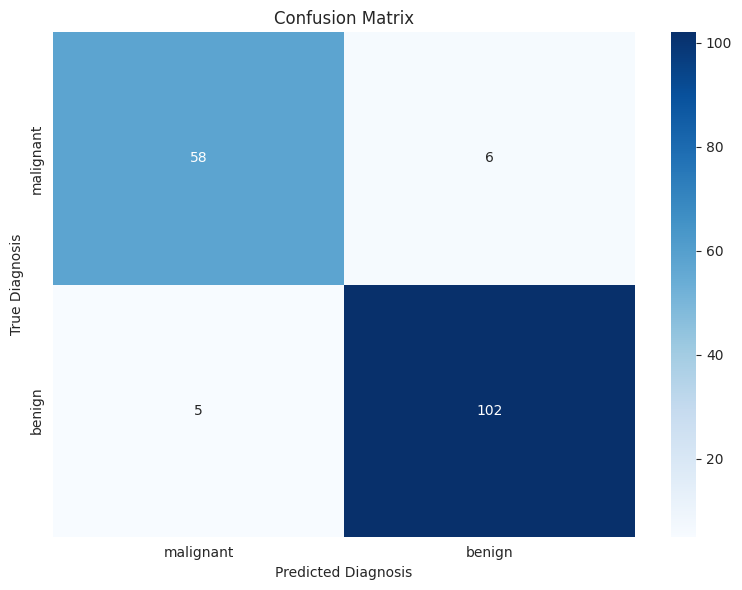

In [7]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Diagnostic Accuracy: {accuracy:.1%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(class_names.values())))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.ylabel('True Diagnosis')
plt.xlabel('Predicted Diagnosis')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 3. Create Medical Case Explainer

The explainer will find similar patient cases from the training data.

In [8]:
# Create explainer with ball_tree (better for 30 features)
explainer = CaseExplainer(
    X_train=X_train,
    y_train=y_train,
    feature_names=feature_names,
    class_names=class_names,
    algorithm='ball_tree',
    scale_data=True  # Important: standardize medical measurements
)

print(f"Medical case database initialized with {len(X_train)} patient records")

Building k-NN index (k=5, metric=euclidean, algorithm=ball_tree)...
Index built on 398 training samples
Medical case database initialized with 398 patient records


## 4. Explain a Diagnosis

Let's explain a diagnosis by finding similar patient cases.

In [9]:
# Select a test patient
patient_idx = 0
patient_sample = X_test[patient_idx]
true_diagnosis = y_test[patient_idx]

# Get explanation with 5 similar cases
explanation = explainer.explain_instance(
    test_sample=patient_sample,
    k=5,
    model=clf,
    true_class=true_diagnosis
)

print("=" * 70)
print("DIAGNOSTIC EXPLANATION")
print("=" * 70)
print(f"\nPredicted diagnosis: {class_names[explanation.predicted_class].upper()}")
print(f"True diagnosis: {class_names[explanation.true_class].upper()}")
print(f"Diagnosis correct: {explanation.is_correct()}")
print(f"\nDiagnostic confidence (correspondence): {explanation.correspondence:.1%}")
print(f"Confidence level: {explanation.correspondence_interpretation}")

print(f"\n{'='*70}")
print("SIMILAR PATIENT CASES:")
print(f"{'='*70}")
for i, neighbor in enumerate(explanation.neighbors, 1):
    print(f"\n{i}. Patient #{neighbor.index}")
    print(f"   Diagnosis: {class_names[neighbor.label]}")
    print(f"   Similarity: {1/(neighbor.distance+1):.3f} (distance: {neighbor.distance:.3f})")
    print(f"   Key features: mean radius={neighbor.features[0]:.1f}, "
          f"mean texture={neighbor.features[1]:.1f}")

DIAGNOSTIC EXPLANATION

Predicted diagnosis: MALIGNANT
True diagnosis: MALIGNANT
Diagnosis correct: True

Diagnostic confidence (correspondence): 100.0%
Confidence level: high

SIMILAR PATIENT CASES:

1. Patient #94
   Diagnosis: malignant
   Similarity: 0.259 (distance: 2.859)
   Key features: mean radius=12.8, mean texture=22.3

2. Patient #97
   Diagnosis: malignant
   Similarity: 0.226 (distance: 3.423)
   Key features: mean radius=14.5, mean texture=27.5

3. Patient #196
   Diagnosis: malignant
   Similarity: 0.216 (distance: 3.633)
   Key features: mean radius=14.9, mean texture=22.5

4. Patient #328
   Diagnosis: malignant
   Similarity: 0.211 (distance: 3.731)
   Key features: mean radius=14.6, mean texture=21.5

5. Patient #187
   Diagnosis: malignant
   Similarity: 0.206 (distance: 3.859)
   Key features: mean radius=11.1, mean texture=18.8


### Understanding Correspondence

**Correspondence** measures how similar a test case is to its nearest neighbors of the same predicted class. It indicates how "typical" or "representative" a case is within the training data:

- **Higher correspondence**: The case closely resembles other cases with the same diagnosis
- **Lower correspondence**: The case is more unusual or atypical compared to similar diagnoses in the training set

**Important**: Correspondence is a descriptive metric showing pattern similarity, not a prescriptive clinical threshold. Domain experts should determine what correspondence values are meaningful in their specific context.

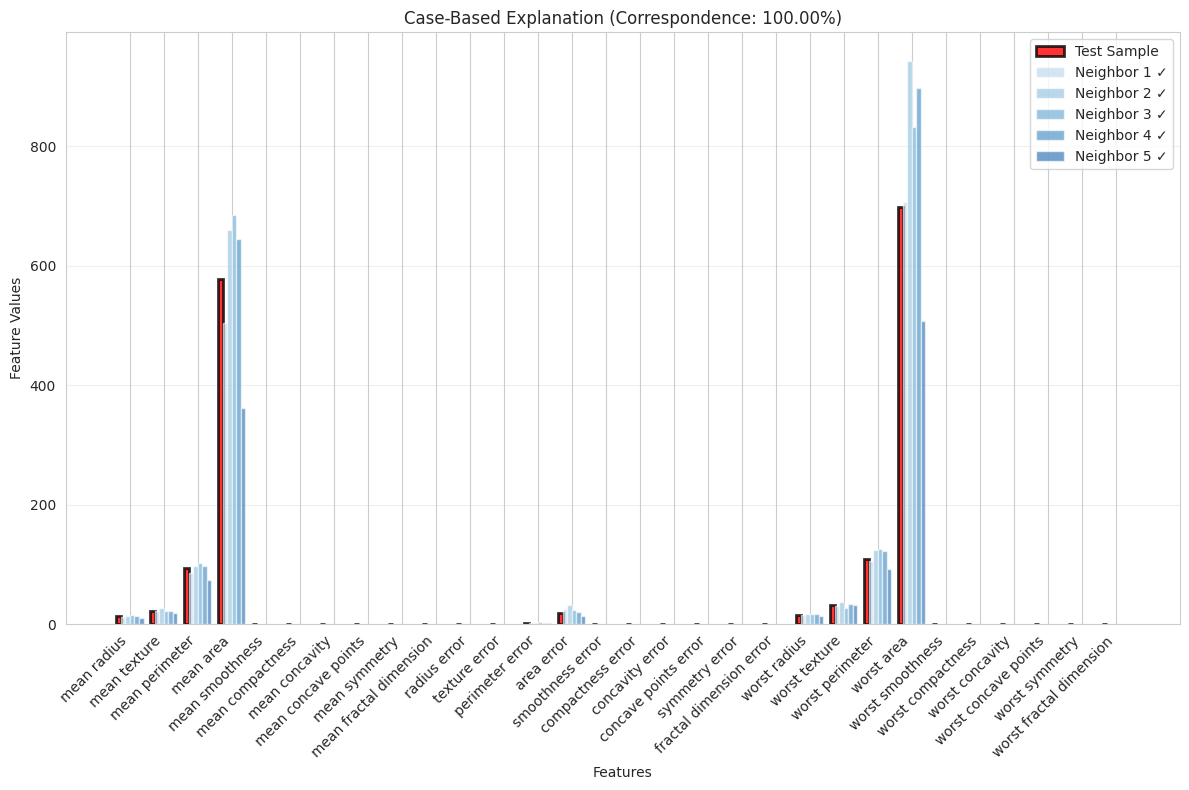

In [14]:
# Visualize the explanation
explanation.plot(plot_type='bar')

## 5. Batch Diagnostic Explanations

Explain all test cases to analyze diagnostic confidence patterns.

In [ ]:
# Generate explanations for all test patients
explanations = explainer.explain_batch(
    X_test=X_test,
    k=5,
    y_test=y_test,
    model=clf
)

print(f"Generated explanations for {len(explanations)} patients")

# Extract statistics
correspondences = [exp.correspondence for exp in explanations]
correct_corr = [exp.correspondence for exp in explanations if exp.is_correct()]
incorrect_corr = [exp.correspondence for exp in explanations if not exp.is_correct()]

print(f"\nCorrespondence Statistics:")
print(f"  Overall mean: {np.mean(correspondences):.1%}")
print(f"  Overall std dev: {np.std(correspondences):.1%}")
print(f"  Correct predictions: {np.mean(correct_corr):.1%} mean")
if incorrect_corr:
    print(f"  Incorrect predictions: {np.mean(incorrect_corr):.1%} mean")
    print(f"  Difference: {np.mean(correct_corr) - np.mean(incorrect_corr):.1%}")

# Show distribution with quartiles
q1, median, q3 = np.percentile(correspondences, [25, 50, 75])
print(f"\nDistribution (quartiles):")
print(f"  25th percentile: {q1:.1%}")
print(f"  Median: {median:.1%}")
print(f"  75th percentile: {q3:.1%}")

Generated explanations for 171 patients

Diagnostic Confidence Statistics:
  Overall mean: 92.9%
  Correct diagnoses: 96.2%
  Incorrect diagnoses: 45.6%
  Confidence gap: 50.5%

Confidence Distribution:
  High confidence (≥85%): 142 patients (83.0%)
  Medium confidence (70-85%): 14 patients (8.2%)
  Low confidence (<70%): 15 patients (8.8%)


## 6. Analyze Correspondence by Diagnosis Type

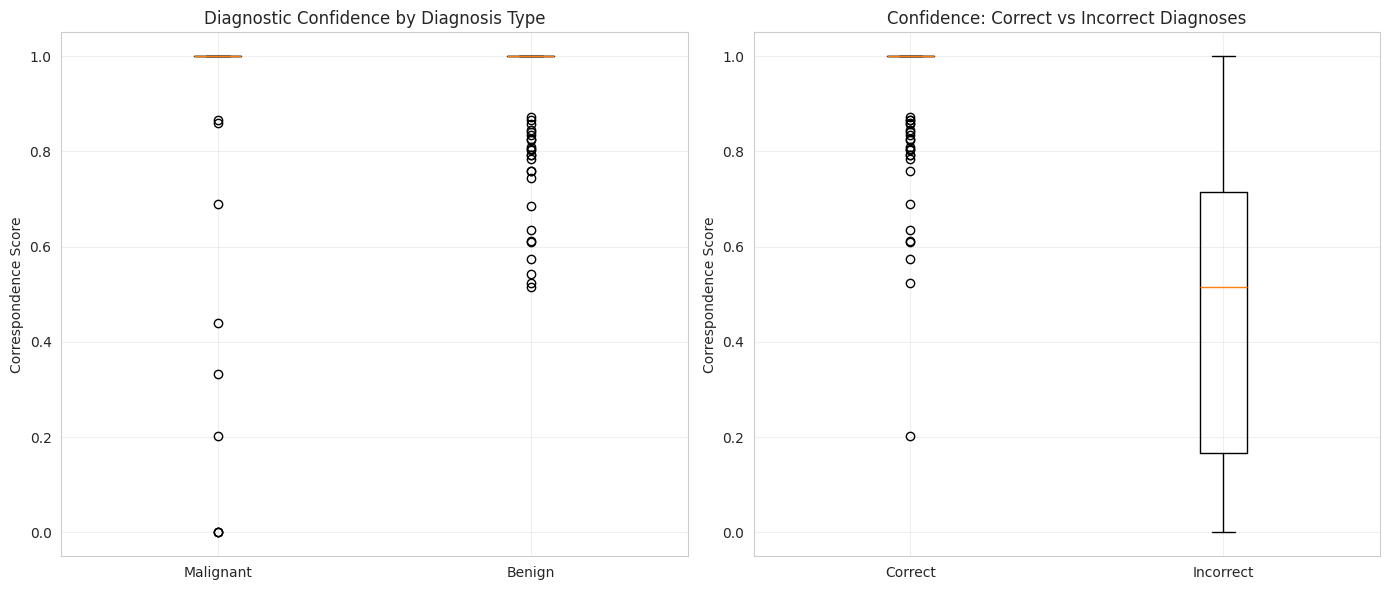


Malignant cases: 91.1% avg confidence
Benign cases: 94.0% avg confidence


In [17]:
# Separate by diagnosis
malignant_corr = [exp.correspondence for exp in explanations if exp.predicted_class == 0]
benign_corr = [exp.correspondence for exp in explanations if exp.predicted_class == 1]

# Create box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# By diagnosis type
axes[0].boxplot([malignant_corr, benign_corr], tick_labels=['Malignant', 'Benign'])
axes[0].set_ylabel('Correspondence Score')
axes[0].set_title('Diagnostic Confidence by Diagnosis Type')
axes[0].grid(alpha=0.3)

# Correct vs Incorrect
if incorrect_corr:
    axes[1].boxplot([correct_corr, incorrect_corr], tick_labels=['Correct', 'Incorrect'])
    axes[1].set_ylabel('Correspondence Score')
    axes[1].set_title('Confidence: Correct vs Incorrect Diagnoses')
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'All diagnoses correct!', 
                ha='center', va='center', fontsize=14)
    axes[1].set_title('Perfect Diagnostic Accuracy')

plt.tight_layout()
plt.show()

print(f"\nMalignant cases: {np.mean(malignant_corr):.1%} avg confidence")
print(f"Benign cases: {np.mean(benign_corr):.1%} avg confidence")

## 7. Identify Atypical Cases

Cases with lower correspondence scores are more atypical - they don't closely match common patterns in the training data. These may warrant closer examination by domain experts.

In [ ]:
# Find cases in the lower quartile of correspondence
threshold = np.percentile(correspondences, 25)  # Bottom 25%
atypical_cases = [exp for exp in explanations if exp.correspondence <= threshold]

print(f"Cases in lower quartile (≤{threshold:.1%} correspondence): {len(atypical_cases)}\n")
print("=" * 70)
print("MOST ATYPICAL CASES (lowest correspondence):")
print("=" * 70)

# Sort by correspondence and show the 5 most atypical
atypical_sorted = sorted(atypical_cases, key=lambda x: x.correspondence)
for i, exp in enumerate(atypical_sorted[:5], 1):
    print(f"\n{i}. Test case index {exp.test_index}")
    print(f"   Predicted: {class_names[exp.predicted_class]}")
    print(f"   True diagnosis: {class_names[exp.true_class]}")
    print(f"   Correspondence: {exp.correspondence:.1%}")
    print(f"   Correct: {exp.is_correct()}")
    print(f"   Note: Does not closely match typical training patterns")

Found 15 cases with low confidence (<70%)

CASES RECOMMENDED FOR ADDITIONAL REVIEW:

1. Patient (test index 15)
   Predicted: malignant
   True diagnosis: malignant
   Correspondence: 20.3%
   Correct: True
   Reason: Unusual case - doesn't match typical patterns

2. Patient (test index 17)
   Predicted: malignant
   True diagnosis: benign
   Correspondence: 33.4%
   Correct: False
   Reason: Unusual case - doesn't match typical patterns

3. Patient (test index 18)
   Predicted: benign
   True diagnosis: benign
   Correspondence: 63.5%
   Correct: True
   Reason: Unusual case - doesn't match typical patterns

4. Patient (test index 22)
   Predicted: benign
   True diagnosis: benign
   Correspondence: 61.0%
   Correct: True
   Reason: Unusual case - doesn't match typical patterns

5. Patient (test index 30)
   Predicted: benign
   True diagnosis: benign
   Correspondence: 61.2%
   Correct: True
   Reason: Unusual case - doesn't match typical patterns


## 8. False Positive/Negative Analysis

In [19]:
# Analyze misclassifications
false_positives = [exp for exp in explanations 
                  if exp.predicted_class == 1 and exp.true_class == 0]  # Said benign but malignant
false_negatives = [exp for exp in explanations 
                  if exp.predicted_class == 0 and exp.true_class == 1]  # Said malignant but benign

print("Diagnostic Errors Analysis:\n")
print(f"False Positives (missed malignant): {len(false_positives)}")
if false_positives:
    fp_corr = [exp.correspondence for exp in false_positives]
    print(f"  Average correspondence: {np.mean(fp_corr):.1%}")
    print(f"  Note: Lower correspondence often indicates uncertain diagnosis")

print(f"\nFalse Negatives (false alarm): {len(false_negatives)}")
if false_negatives:
    fn_corr = [exp.correspondence for exp in false_negatives]
    print(f"  Average correspondence: {np.mean(fn_corr):.1%}")
    print(f"  Note: Lower correspondence often indicates uncertain diagnosis")

if not false_positives and not false_negatives:
    print("\nPerfect diagnostic accuracy! All cases correctly classified.")

Diagnostic Errors Analysis:

False Positives (missed malignant): 6
  Average correspondence: 70.8%
  Note: Lower correspondence often indicates uncertain diagnosis

False Negatives (false alarm): 5
  Average correspondence: 15.5%
  Note: Lower correspondence often indicates uncertain diagnosis


## 9. Correspondence Distribution

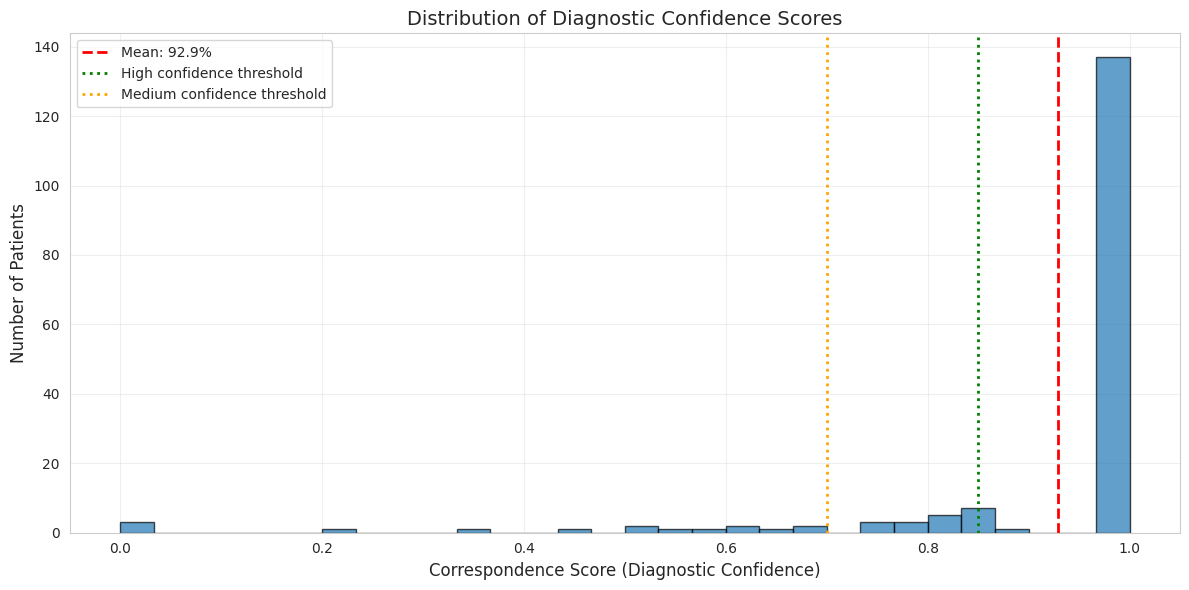

In [ ]:
# Create detailed histogram
plt.figure(figsize=(12, 6))
plt.hist(correspondences, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(correspondences), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(correspondences):.1%}')
plt.axvline(median, color='blue', linestyle='--', linewidth=2,
            label=f'Median: {median:.1%}')
plt.xlabel('Correspondence Score', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Distribution of Correspondence Scores', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Understanding the Tool's Output

### What Case-Explainer Provides

**1. Transparency Through Examples**
- Shows *which specific* training cases support each prediction
- Allows domain experts to verify if the reasoning makes sense
- Makes the model's decision process inspectable

**2. Correspondence as a Similarity Metric**
- Measures how typical a case is compared to training data
- Higher values: case closely matches common patterns
- Lower values: case is more unusual or atypical
- Purely descriptive - not a clinical decision threshold

**3. Pattern Recognition, Not Clinical Judgment**
- The tool identifies similar cases and calculates correspondence
- It does NOT determine what correspondence values are "good" or "bad"
- It does NOT prescribe clinical actions or workflows
- Domain experts must interpret results in their clinical context

### Key Observations from This Dataset

- Correct predictions tend to have higher mean correspondence than incorrect ones
- There is variation in correspondence across both diagnosis types
- Some atypical cases (lower correspondence) are still correctly classified
- The distribution shows where most cases fall relative to the training data

### Important Limitations

**This is a software tool, not a medical device:**
- Correspondence thresholds are NOT clinically validated
- The tool shows patterns but cannot replace clinical judgment
- Medical decisions require:
  - Clinical expertise and training
  - Patient history and context
  - Additional diagnostic information
  - Institutional protocols and guidelines

**For Clinical Applications:**
- Domain experts should evaluate correspondence values in context
- Determine appropriate thresholds based on clinical validation studies
- Use as one input among many in diagnostic workflows
- Always follow established medical protocols and standards of care

### Using Case-Explainer Responsibly

**Good Uses:**
- Understanding what training cases influence predictions
- Identifying cases that don't match typical patterns (for expert review)
- Building trust through transparency
- Research and algorithm evaluation

**Inappropriate Uses:**
- Setting universal "confidence thresholds" without domain validation
- Making clinical decisions based solely on correspondence scores
- Replacing expert judgment with algorithmic outputs
- Assuming the tool's metrics are clinically meaningful without validation

## Next Steps

Try the other domain tutorials:
- `03_fraud_detection_tutorial.ipynb` - Financial domain with extreme imbalance
- `04_hardware_trojan_tutorial.ipynb` - Security domain with large-scale data

Each domain requires different expertise to interpret results appropriately.